In [1]:
import sys
import os
import warnings
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from itertools import product


# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('weld_quality_prediction'), '..')))

from data_preprocessing.functions import replace_data, choose_labels, pipeline_training_set
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('../data/welddb.data', sep=' ', header=None)

column_names = [
    "Carbon_concentration",
    "Silicon_concentration",
    "Manganese_concentration",
    "Sulphur_concentration",
    "Phosphorus_concentration",
    "Nickel_concentration",
    "Chromium_concentration",
    "Molybdenum_concentration",
    "Vanadium_concentration",
    "Copper_concentration",
    "Cobalt_concentration",
    "Tungsten_concentration",
    "Oxygen_concentration",
    "Titanium_concentration",
    "Nitrogen_concentration",
    "Aluminium_concentration",
    "Boron_concentration",
    "Niobium_concentration",
    "Tin_concentration",
    "Arsenic_concentration",
    "Antimony_concentration",
    "Current",
    "Voltage",
    "AC_or_DC",
    "Electrode_positive_or_negative",
    "Heat_input",
    "Interpass_temperature",
    "Type_of_weld",
    "Post_weld_heat_treatment_temperature",
    "Post_weld_heat_treatment_time",
    "Yield_strength",
    "Ultimate_tensile_strength",
    "Elongation",
    "Reduction_of_Area",
    "Charpy_temperature",
    "Charpy_impact_toughness",
    "Hardness",
    "50%_FATT",
    "Primary_ferrite_in_microstructure",
    "Ferrite_with_second_phase",
    "Acicular_ferrite",
    "Martensite",
    "Ferrite_with_carbide_aggregate",
    "Weld_ID"
]

sulphur_and_phosphorus_columns = ["Sulphur_concentration","Phosphorus_concentration"]

other_concentration_columns = ["Carbon_concentration",
        "Silicon_concentration",
        "Manganese_concentration",
        "Nickel_concentration",
        "Chromium_concentration",
        "Molybdenum_concentration",
        "Vanadium_concentration",
        "Copper_concentration",
        "Cobalt_concentration",
        "Tungsten_concentration",
        "Oxygen_concentration",
        "Titanium_concentration",
        "Nitrogen_concentration",
        'Nitrogen_concentration_residual',
        "Aluminium_concentration",
        "Boron_concentration",
        "Niobium_concentration",
        "Tin_concentration",
        "Arsenic_concentration",
        "Antimony_concentration"]

label_names = ['Yield_strength', 'Ultimate_tensile_strength', 'Elongation', 'Reduction_of_Area', 'Charpy_temperature', 
                   'Charpy_impact_toughness', 'Hardness', '50%_FATT', 'Primary_ferrite_in_microstructure', 'Ferrite_with_second_phase', 
                   'Acicular_ferrite', 'Martensite', 'Ferrite_with_carbide_aggregate', 'Hardness_load']

physical_ordinal_properties_columns = [
        'Current', 
        'Voltage',
        'Heat_input',
        'Interpass_temperature',
        'Post_weld_heat_treatment_temperature',
        'Post_weld_heat_treatment_time', 
    ]

physical_categorical_properties_columns = [
    'AC_or_DC',
    'Electrode_positive_or_negative',
    'Type_of_weld'
]

data.columns = column_names

In [3]:
# Suppress all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

#Selection of the targets
labels_selected = ["Yield_strength"]

#Replace 'N' value with Nan
data = replace_data(data)

#Selection fof the data for supervised learning
data_with_label = data.copy()
data_with_label = data[data_with_label[labels_selected].notna().all(axis=1)]

#Separation of features and labels
X, y = choose_labels(data_with_label, labels_chosen=labels_selected)


# Neural Network

## Model

In [4]:
# Neural network

# Define the neural network
class Net(nn.Module):
    def __init__(self, layers, n_layers, activation=nn.ReLU, dropout=True, dropout_rate=0.5):
        super(Net, self).__init__()
        self.n_layers = n_layers
        self.activation = activation
        self.dropout = dropout
        self.dropout_rate = dropout_rate
        for i in range(n_layers):
            setattr(self, f'fc{i}', nn.Linear(layers[i][0], layers[i][1]))

    def forward(self, x):
        for i in range(self.n_layers-1):
            x = getattr(self, f'fc{i}')(x)
            x = self.activation()(x)
            if self.dropout == True:
                x = nn.Dropout(self.dropout_rate)(x)
        x = getattr(self, f'fc{self.n_layers-1}')(x)
        x = self.activation()(x)
        return x
    


c:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Training

def train_loop(dataloader, model, loss_fn, optimizer, batch_size, visualize=False):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        #  Reset the gradients to zero
        optimizer.zero_grad()

        # Print the progress of the training
        if batch % 10 == 0 and batch != 0 and visualize == True:
            loss, current = np.sqrt(loss.item()), batch * batch_size + len(X)
            print(f"Mean loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



def test_loop(dataloader, model, loss_fn, visualize=False):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss = 0
    total_samples = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item() * X.size(0)
            total_samples += X.size(0)
    test_loss /= total_samples
    if visualize == True:
        print(f"Test Error: {np.sqrt(test_loss):>8f} \n")
    return np.sqrt(test_loss)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

In [96]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

best_parameters = {'lr': 0.01, 'n_epochs': 50, 'batch_size': 4, 'weight_decay': 0.01, 'dropout': False, 'layer_def': [4, 4], 'ordinal_strategy': 'mean', 'categorical_strategy': 'logistic', 'is_PCA': True, 'pca_percent_explained_variance': 0.9, 'pca_columns': 'all_ordinals'}

# Define the learning rate
lr = 0.01

# Activation function
activation = nn.ReLU

# Define weight decay: L2 regularization. It adds a penalty to the loss function based on the magnitude of the weights, 
                        # which helps to prevent the weights from becoming too large.
weight_decay = 0.01

# Dropout: a regularization technique that prevents overfitting by randomly setting a fraction of the input units 
            # to 0 at each update during training time.
dropout = False

# Define the number of epochs
n_epochs = 50

# Define the batch size
batch_size = 4

# Layers
layer_def = [4, 4]

# Parameters
categorical_strategy="logistic"
ordinal_strategy="mean"
is_PCA=True
pca_percent_explained_variance=0.9
pca_columns="all_ordinals"


def create_and_train(X_train, X_test, y_train, y_test, layer_def, ordinal_strategy, categorical_strategy, is_PCA, pca_percent_explained_variance, 
                     pca_columns, activation, lr, weight_decay, dropout, n_epochs, batch_size, scaler_strategy="standard", visualize=False):
    # Preprocess the data
    X_train, X_test, y_train, y_test = pipeline_training_set(training_set=X_train, training_labels=y_train, testing_set=X_test, testing_labels=y_test, 
                                                            labels_chosen=labels_selected, categorical_strategy=categorical_strategy, \
                                                            ordinal_strategy=ordinal_strategy, is_PCA=is_PCA, 
                                                            pca_percent_explained_variance=pca_percent_explained_variance, 
                                                            scaler_strategy=scaler_strategy, pca_columns=pca_columns, less_than_strategy="mean")

    # Get the input size
    input_size = X_train.shape[1]
    
    # Convert the data to PyTorch tensors
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    X_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32)
    y_test = torch.tensor(y_test.values, dtype=torch.float32)

    # Set the seed for reproducibility
    seed = 42
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Define the model
    activation = activation
    n_layers = len(layer_def)
    layers = [(input_size, layer_def[0])]
    for i in range(1, n_layers):
        layers.append((layer_def[i-1], layer_def[i]))
    layers.append((layer_def[n_layers-1], 1))
    
    model = Net(layers, n_layers+1, activation=activation, dropout=dropout, dropout_rate=0.2)
    
    # Get the number of hyperparameters
    # num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # print(f"Number of hyperparameters: {num_params}")
    # print("Number of training data:", len(X_train))


    # Define the loss function
    loss_fn = nn.MSELoss()

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Create the dataset
    train_dataset = CustomDataset(X_train, y_train)
    test_dataset = CustomDataset(X_test, y_test)

    # Create the dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    # Train the model
    for t in range(n_epochs):
        if visualize == True:
            print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, batch_size, visualize=visualize)
    return model, X_test, y_test, test_dataloader, loss_fn

model, X_test, y_test, test_dataloader, loss_fn = create_and_train(X_train, X_test, y_train, y_test, layer_def, ordinal_strategy, 
                                                                   categorical_strategy, is_PCA, pca_percent_explained_variance, pca_columns, 
                                                                   activation, lr, weight_decay, dropout, n_epochs, batch_size, visualize=True)

Epoch 1
-------------------------------
Mean loss: 489.898810  [   44/  702]
Mean loss: 491.429102  [   84/  702]
Mean loss: 521.849296  [  124/  702]
Mean loss: 529.871683  [  164/  702]
Mean loss: 532.555191  [  204/  702]
Mean loss: 433.059844  [  244/  702]
Mean loss: 385.205424  [  284/  702]
Mean loss: 436.260530  [  324/  702]
Mean loss: 424.701219  [  364/  702]
Mean loss: 389.977583  [  404/  702]
Mean loss: 360.335239  [  444/  702]
Mean loss: 330.368781  [  484/  702]
Mean loss: 240.465109  [  524/  702]
Mean loss: 149.545934  [  564/  702]
Mean loss: 77.302233  [  604/  702]
Mean loss: 180.060808  [  644/  702]
Mean loss: 94.087569  [  684/  702]
Epoch 2
-------------------------------
Mean loss: 81.430044  [   44/  702]
Mean loss: 91.536120  [   84/  702]
Mean loss: 72.784943  [  124/  702]
Mean loss: 163.304894  [  164/  702]
Mean loss: 72.062049  [  204/  702]
Mean loss: 60.452937  [  244/  702]
Mean loss: 95.440713  [  284/  702]
Mean loss: 78.366109  [  324/  702]
Mean

In [97]:
# Test the model
test_error = test_loop(test_dataloader, model, loss_fn, visualize=True)

Test Error: 75.573953 



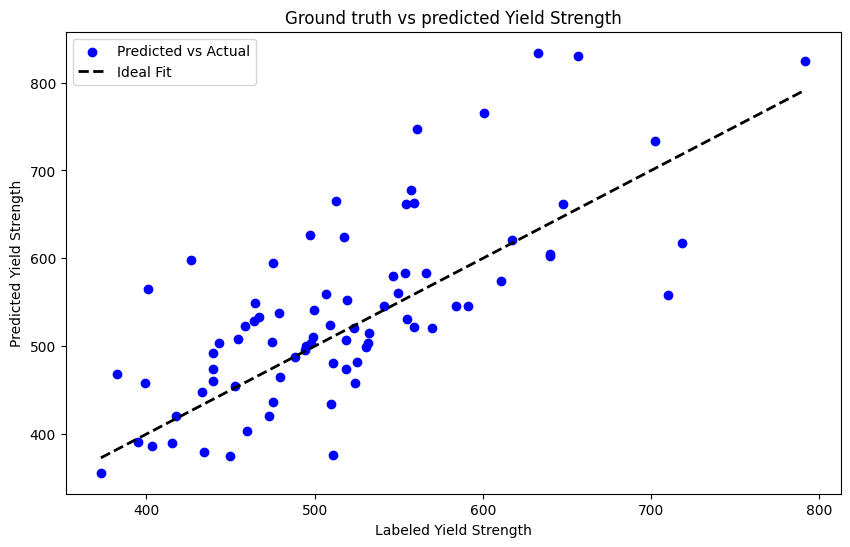

In [99]:
# Plot the results

new_y_test = model(X_test).detach().numpy()

# Convert new_y_test to a numpy array for plotting
new_y_test_values = new_y_test

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(new_y_test_values, y_test.detach().numpy(), color='blue', label='Predicted vs Actual')
plt.plot([new_y_test_values.min(), new_y_test_values.max()], [new_y_test_values.min(), new_y_test_values.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Labeled Yield Strength')
plt.ylabel('Predicted Yield Strength')
plt.title('Ground truth vs predicted Yield Strength')
plt.legend()
plt.show()

## Finding best hyperparameters with grid Search 

In [101]:
# Grid Search

# Suppress all warnings
warnings.filterwarnings("ignore")

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

# Define the grid search parameters

# Define the learning rate
lr = [0.01, 0.001]
# Define the number of epochs
n_epochs = [30, 40, 50]
# Define the batch size
batch_size = [4, 8, 16] 
# Activation functions
activation = nn.ReLU
# Define the weight decay
weight_decay = [0.01, 0.05]
# Dropout
dropout = [False, True]
# Layers
layer_def = [[4], [8], [16], [4, 4], [8, 8], [16, 16]]
# Parameters
categorical_strategy = ["most_frequent", "logistic"]
ordinal_strategy = ["mean", "linear"]
is_PCA = [True]
pca_percent_explained_variance = [0.85, 0.9]
pca_columns = ["all_ordinals", "concentrations"]

parameters = {
    "lr": lr, 
    "n_epochs": n_epochs, 
    "batch_size": batch_size,
    "weight_decay": weight_decay,
    "dropout": dropout,
    "layer_def": layer_def, 
    "ordinal_strategy": ordinal_strategy, 
    "categorical_strategy": categorical_strategy, 
    "is_PCA": is_PCA, 
    "pca_percent_explained_variance": pca_percent_explained_variance, 
    "pca_columns": pca_columns
}

# Initialize the best model and score
best_model = None
best_score = float('inf')
best_parameters = {"lr": None, 
    "n_epochs": None, 
    "batch_size": None, 
    "weight_decay": None,
    "dropout": None,
    "layer_def": None, 
    "ordinal_strategy": None, 
    "categorical_strategy": None, 
    "is_PCA": None, 
    "pca_percent_explained_variance": None, 
    "pca_columns": None
}
best_models = []


# Prepare the K-Fold Cross Validation
from sklearn.model_selection import KFold
n_splits = 3
kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)

# Loop through all the parameters
for lr, n_epochs, batch_size, weight_decay, dropout, layer_def, ordinal_strategy, categorical_strategy, is_PCA, pca_percent_explained_variance, pca_columns in product(
    parameters["lr"], 
    parameters["n_epochs"], 
    parameters["batch_size"], 
    parameters["weight_decay"],
    parameters["dropout"],
    parameters["layer_def"], 
    parameters["ordinal_strategy"], 
    parameters["categorical_strategy"], 
    parameters["is_PCA"], 
    parameters["pca_percent_explained_variance"], 
    parameters["pca_columns"]
):
    print(f"Testing combination: lr={lr}, n_epochs={n_epochs}, batch_size={batch_size}, weight_decay={weight_decay}, dropout={dropout}, layer_def={layer_def}, ordinal_strategy={ordinal_strategy}, categorical_strategy={categorical_strategy}, is_PCA={is_PCA}, pca_percent_explained_variance={pca_percent_explained_variance}, pca_columns={pca_columns}")
    
    score = 0
    
    # K-Fold Cross Validation
    for train_index, test_index in kf.split(X_train):
        X_train_k, X_test_k = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_k, y_test_k = y_train.iloc[train_index], y_train.iloc[test_index]
        
        model, current_X_test, current_y_test, test_dataloader, loss_fn = create_and_train(X_train_k, X_test_k, y_train_k, y_test_k, 
                                                        layer_def, ordinal_strategy, categorical_strategy, is_PCA, 
                                                        pca_percent_explained_variance, pca_columns, activation, 
                                                        lr, weight_decay, dropout, n_epochs, batch_size, visualize=False)  
        
        score += test_loop(test_dataloader, model, loss_fn)
        
    score /= n_splits
    print("\n Mean Scores: ", score, "\n")
    if score < best_score:
        best_score = score
        best_model = model
        best_parameters["lr"] = lr
        best_parameters["n_epochs"] = n_epochs
        best_parameters["batch_size"] = batch_size
        best_parameters["weight_decay"] = weight_decay
        best_parameters["dropout"] = dropout
        best_parameters["layer_def"] = layer_def
        best_parameters["ordinal_strategy"] = ordinal_strategy
        best_parameters["categorical_strategy"] = categorical_strategy
        best_parameters["is_PCA"] = is_PCA
        best_parameters["pca_percent_explained_variance"] = pca_percent_explained_variance
        best_parameters["pca_columns"] = pca_columns
    
    if score < 100:
        best_models.append({"model": model, "score": score, "parameters": {"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size, "weight_decay": weight_decay, "dropout": dropout, "layer_def": layer_def, "ordinal_strategy": ordinal_strategy, "categorical_strategy": categorical_strategy, "is_PCA": is_PCA, "pca_percent_explained_variance": pca_percent_explained_variance, "pca_columns": pca_columns}})

print("Best parameters: ", best_parameters)
print("Best score: ", best_score)
print("Best models: ", best_models)


Testing combination: lr=0.01, n_epochs=30, batch_size=4, weight_decay=0.01, dropout=False, layer_def=[4, 4], ordinal_strategy=mean, categorical_strategy=logistic, is_PCA=True, pca_percent_explained_variance=0.9, pca_columns=all_ordinals

 Mean Scores:  85.1193931195358 

Testing combination: lr=0.01, n_epochs=40, batch_size=4, weight_decay=0.01, dropout=False, layer_def=[4, 4], ordinal_strategy=mean, categorical_strategy=logistic, is_PCA=True, pca_percent_explained_variance=0.9, pca_columns=all_ordinals

 Mean Scores:  83.71243562174412 

Testing combination: lr=0.01, n_epochs=50, batch_size=4, weight_decay=0.01, dropout=False, layer_def=[4, 4], ordinal_strategy=mean, categorical_strategy=logistic, is_PCA=True, pca_percent_explained_variance=0.9, pca_columns=all_ordinals

 Mean Scores:  82.85544540008891 

Testing combination: lr=0.01, n_epochs=60, batch_size=4, weight_decay=0.01, dropout=False, layer_def=[4, 4], ordinal_strategy=mean, categorical_strategy=logistic, is_PCA=True, pca_pe

In [92]:
# Test the best model on the test set

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

# Best parameters
best_parameters = {'lr': 0.01, 'n_epochs': 50, 'batch_size': 4, 'weight_decay': 0.01, 'dropout': False, 'layer_def': [4, 4], 'ordinal_strategy': 'mean', 'categorical_strategy': 'logistic', 'is_PCA': True, 'pca_percent_explained_variance': 0.9, 'pca_columns': 'all_ordinals'}
#Best score:  82.85544540008891

best_model, best_X_test, best_y_test, best_test_dataloader, best_loss_fn = create_and_train(X_train, X_test, y_train, y_test, 
                                                        best_parameters["layer_def"], best_parameters["ordinal_strategy"], 
                                                        best_parameters["categorical_strategy"], 
                                                        best_parameters["pca_percent_explained_variance"], 
                                                        best_parameters["pca_columns"], nn.ReLU, 
                                                        best_parameters["lr"], best_parameters["weight_decay"], best_parameters["dropout"],
                                                        best_parameters["n_epochs"], 
                                                        best_parameters["batch_size"], scaler_strategy="standard", visualize=False) 

mse = test_loop(best_test_dataloader, best_model, best_loss_fn, visualize=True)
print(mse)

Test Error: 75.573953 

75.5739526805691


## Best hyperparameters for neural network

- PCA percent explained variance = 0.9

- PCA columns: all ordinals

- Validation MSE = 82.85544540008891

- Learning Rate: 0.01

- Weight Decay: 0.01

- Number of Epochs: 50

- Dropout: False

- Batch Size: 4

- Layers: 2 hidden layers of 4 neurones each

- Ordinal Strategy: mean

- Categorical Strategy: logistic

- MSE on test set: 75.5739526805691

- Scaler: standardization